In [5]:
!pip install open3d

In [28]:
import PIL
import matplotlib.pyplot as plt
import cv2 as cv
import time
import numpy as np
from scipy import ndimage as nd
import open3d as o3d
from pathlib import Path
import struct
import customStereo as cs

# Human Reconstruction

In [29]:
def disparityToDepthScanning(disparity):
    depth = 613.33*np.power(disparity.clip(min=0.00001),-1.001)
    depth[depth == 613.33*np.power(0.00001,-1.001)] = 0
    return depth 

def create_pcd(img, depth, f, cx, cy):
        rows, columns = depth.shape

        dy = np.arange(rows).reshape(-1, 1)*np.ones(columns)
        dx = np.arange(columns)*np.ones(rows).reshape(-1, 1)

        x = (dx - cx) * depth / f
        y = (dy - cy) * depth / f

        pcd = np.array([x.flatten(), y.flatten(), depth.flatten()]).transpose()
        pcdRGB = img.reshape(-1, 3)/255
        
        pcd_o3d = o3d.geometry.PointCloud()  
        pcd_o3d.points = o3d.utility.Vector3dVector(pcd)  
        pcd_o3d.colors = o3d.utility.Vector3dVector(pcdRGB) 
        
        return pcd_o3d

(-0.5, 639.5, 479.5, -0.5)

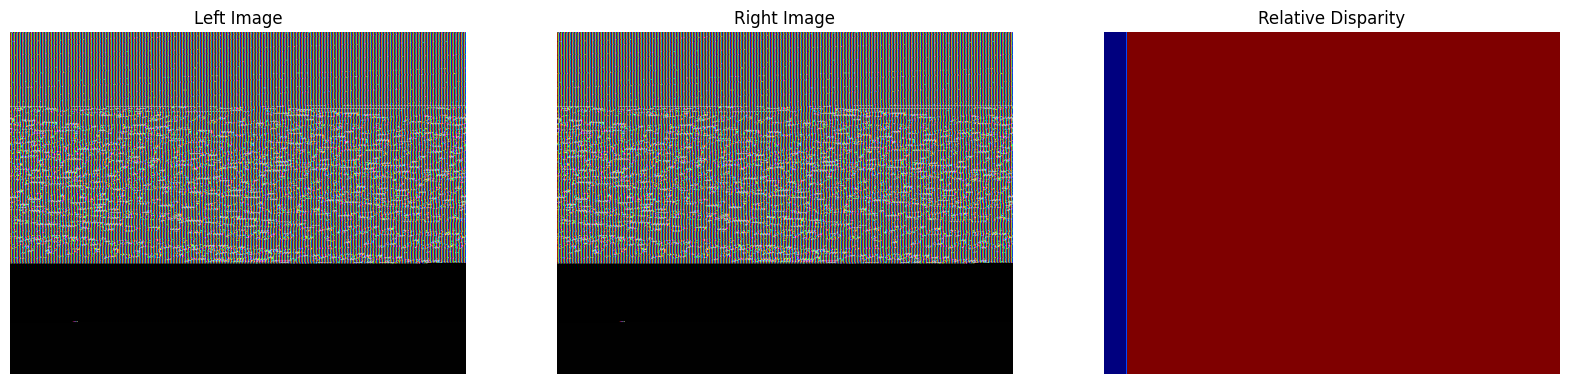

In [30]:
image_L = cv.imread("../Images/daniel_L.jpg")
image_L_gray = cv.cvtColor(image_L, cv.COLOR_BGR2GRAY)
image_L = cv.cvtColor(image_L, cv.COLOR_BGR2RGB)

image_R = cv.imread("../Images/daniel_R.jpg")
image_R = cs.readRight(1)
image_R_gray = cv.cvtColor(image_L, cv.COLOR_BGR2GRAY)
image_R = cv.cvtColor(image_R, cv.COLOR_BGR2RGB)

stereoSGBM = cv.StereoSGBM_create(minDisparity=0, numDisparities=32, blockSize=3, P1=8*3*3, P2=32*3*3, disp12MaxDiff=10, uniquenessRatio=10, speckleWindowSize=150, speckleRange=32)
disparity = stereoSGBM.compute(image_L, image_R)
depth = disparityToDepthScanning(disparity)

disp_vis = np.uint8(255*cv.normalize(disparity,disparity,0,1,cv.NORM_MINMAX,cv.CV_32F)) 
disp_vis = cv.equalizeHist(disp_vis)

plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.imshow(image_L)
plt.title('Left Image')
plt.axis('off')
plt.subplot(132)
plt.imshow(image_R)
plt.title('Right Image')
plt.axis('off')
plt.subplot(133)
plt.imshow(disp_vis, cmap='jet')
plt.title('Relative Disparity')
plt.axis('off')

In [25]:
f = 551.038915543398
cx = 287.359515629467
cy = 269.784821130991

pcd = create_pcd(image_L, depth, f, cx, cy)
o3d.visualization.draw_geometries([pcd], point_show_normal=True)

-16

In [11]:
613.33*np.power(0.0001,-1.001), 613.33*np.power(1,-1.001), 613.33*np.power(np.inf,-1.001)

(6190050.726174123, 613.33, 0.0)

# Disparity Map

In [3]:
image_L = cv.imread('left_piano.png', 0)
image_R = cv.imread('right_piano.png', 0)

In [4]:
stereo = cv.StereoBM_create(numDisparities=64, blockSize=5)
disparity = stereo.compute(image_L, image_R)

dindex = np.where(disparity != -16)
disparity = disparity[dindex[0].min():dindex[0].max(), dindex[1].min():dindex[1].max()]
disparity[disparity == -16] = 0
disparity = np.round(disparity/16)

(-0.5, 638.5, 475.5, -0.5)

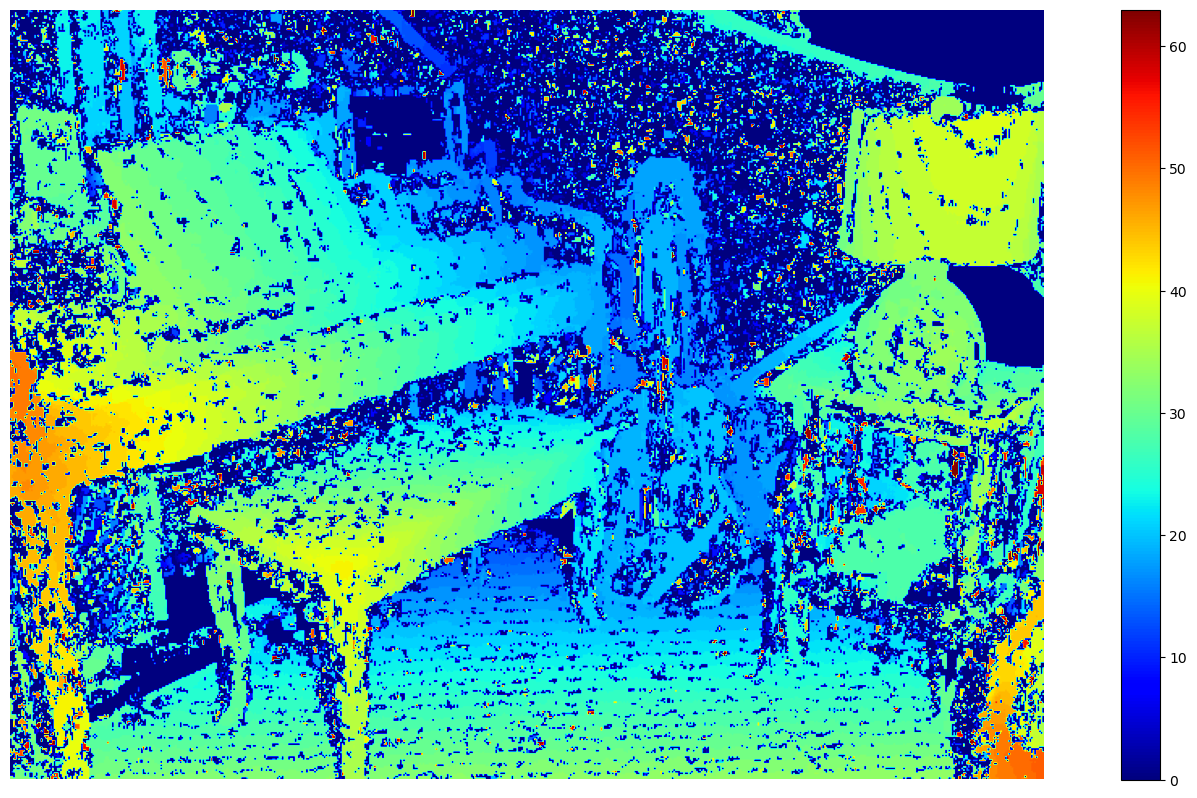

In [5]:
plt.figure(figsize=(20, 10))
plt.imshow(disparity, cmap='jet')
plt.colorbar()
plt.axis('off')

In [6]:
def read_pfm(filename):
    with Path(filename).open('rb') as pfm_file:

        line1, line2, line3 = (pfm_file.readline().decode('latin-1').strip() for _ in range(3))
        assert line1 in ('PF', 'Pf')
        
        channels = 3 if "PF" in line1 else 1
        width, height = (int(s) for s in line2.split())
        scale_endianess = float(line3)
        bigendian = scale_endianess > 0
        scale = abs(scale_endianess)

        buffer = pfm_file.read()
        samples = width * height * channels
        assert len(buffer) == samples * 4
        
        fmt = f'{"<>"[bigendian]}{samples}f'
        decoded = struct.unpack(fmt, buffer)
        shape = (height, width, 3) if channels == 3 else (height, width)
        return np.flipud(np.reshape(decoded, shape)) * scale

In [7]:
GT = read_pfm('piano_GT.pfm')
GT = (GT*260).round()

(-0.5, 2819.5, 1919.5, -0.5)

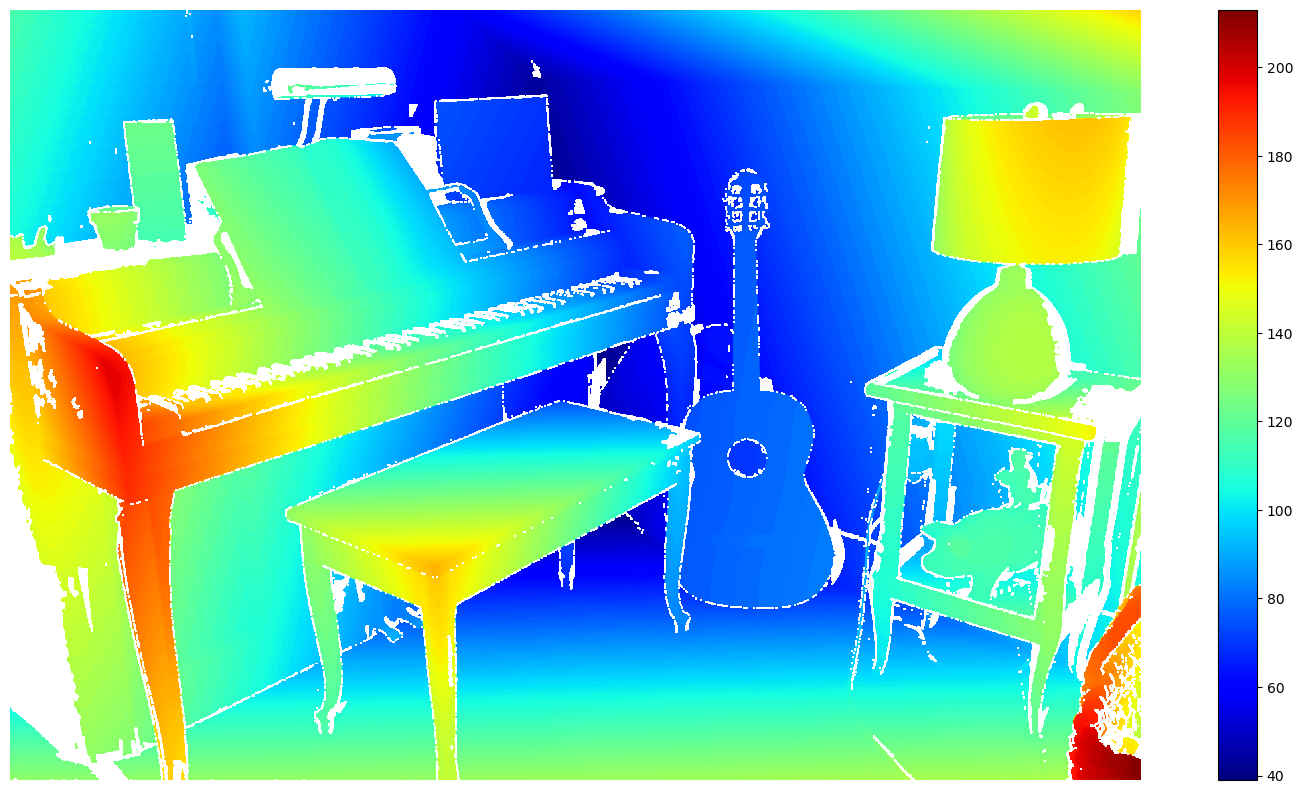

In [8]:
plt.figure(figsize=(20, 10))
plt.imshow(GT, cmap='jet')
plt.colorbar()
plt.axis('off')

# Point Cloud

In [9]:
BGR = cv.imread('big_piano.png')
RGB = cv.cvtColor(BGR, cv.COLOR_BGR2RGB)

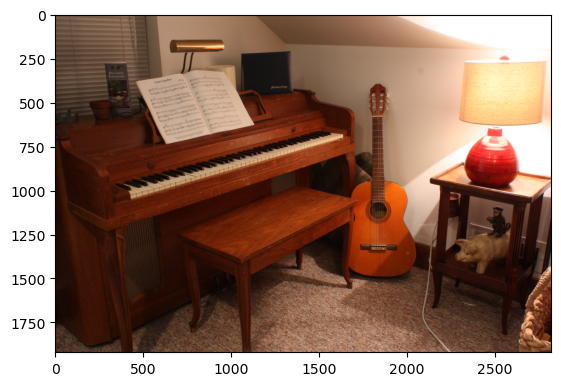

In [10]:
plt.imshow(RGB)

In [11]:
RGB.reshape(-1, 3).shape

(5414400, 3)

In [19]:
b = 178.089
f = 2826.171
depth = b * f / (GT + 123.77)
rows, columns = depth.shape

cx = 1292.2
cy = 965.806

dy = np.arange(rows).reshape(-1, 1)*np.ones(columns)
dx = np.arange(columns)*np.ones(rows).reshape(-1, 1)

x = (dx - cx) * depth / f
y = (dy - cy) * depth / f

pcd = np.array([x.flatten(), y.flatten(), depth.flatten()]).transpose()
pcRGB = RGB.reshape(-1, 3)/255;

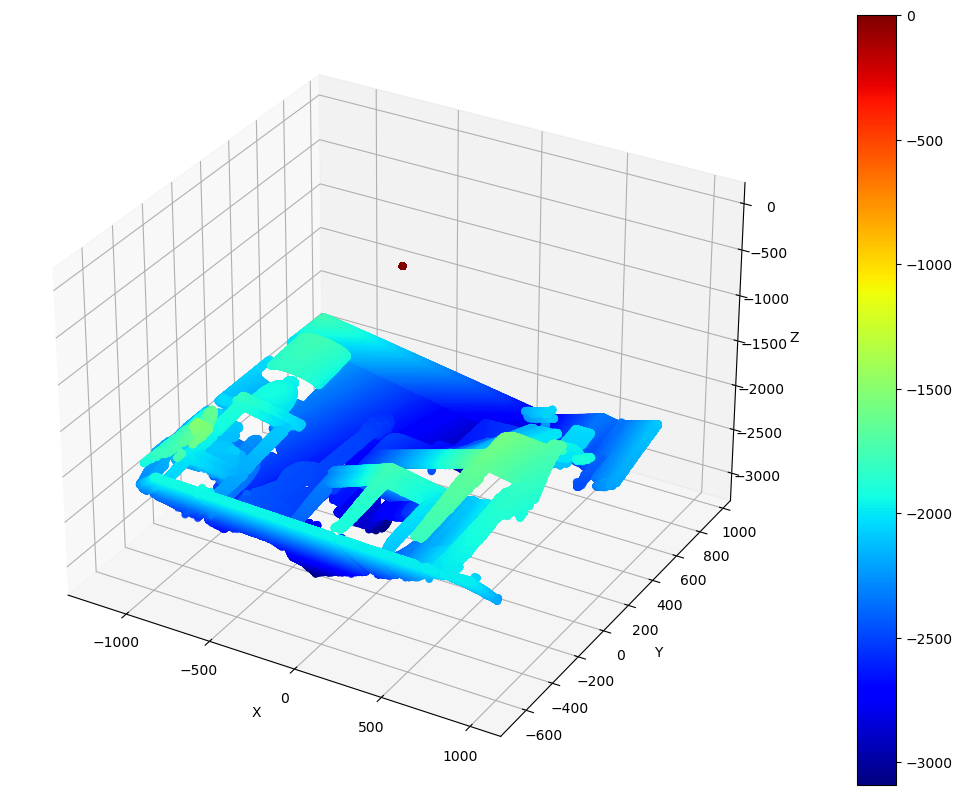

In [13]:
plt.figure(figsize=(20, 10))
ax = plt.axes(projection='3d')
color_map = plt.get_cmap('jet')
scatter_plot = ax.scatter3D(-pcd[:, 0], -pcd[:, 1], -pcd[:, 2], c=-pcd[:, 2], cmap=color_map)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.colorbar(scatter_plot)
plt.show()


In [14]:
plt.figure(figsize=(20, 10))
ax = plt.axes(projection='3d')
color_map = None#plt.get_cmap('jet')
scatter_plot = ax.scatter3D(-pcd[:, 0], -pcd[:, 1], -pcd[:, 2], c=pcRGB, cmap=color_map)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.colorbar(scatter_plot)
plt.show()

KeyboardInterrupt: 

In [16]:
pcd_o3d = o3d.geometry.PointCloud()  # create point cloud object
pcd_o3d.points = o3d.utility.Vector3dVector(pcd)  # set pcd_np as the point cloud points
pcd_o3d.colors = o3d.utility.Vector3dVector(pcRGB) 
# Visualize:
o3d.visualization.draw_geometries([pcd_o3d], point_show_normal=True)

In [ ]:
alpha = 0.3
tetra_mesh, pt_map = o3d.geometry.TetraMesh.create_from_point_cloud(pcd_o3d)
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(
    pcd_o3d, alpha, tetra_mesh, pt_map)
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

Creating, Saving, and opening a Point Cloud

In [17]:
def create_pcd(img, depth, b, f, cx, cy):
        rows, columns = depth.shape

        dy = np.arange(rows).reshape(-1, 1)*np.ones(columns)
        dx = np.arange(columns)*np.ones(rows).reshape(-1, 1)

        x = (dx - cx) * depth / f
        y = (dy - cy) * depth / f

        pcd = np.array([x.flatten(), y.flatten(), depth.flatten()]).transpose()
        pcdRGB = img.reshape(-1, 3)/255
        
        pcd_o3d = o3d.geometry.PointCloud()  
        pcd_o3d.points = o3d.utility.Vector3dVector(pcd)  
        pcd_o3d.colors = o3d.utility.Vector3dVector(pcRGB) 
        
        return pcd_o3d

In [22]:
pointcloud = create_pcd(RGB, depth, b, f, cx, cy)
o3d.io.write_point_cloud("piano.ply", pointcloud)

True

In [23]:
pcd = o3d.io.read_point_cloud("piano.ply")
o3d.visualization.draw_geometries([pcd], point_show_normal=True)

In [27]:
#downpcd = pcd.voxel_down_sample(voxel_size=0.1)
#o3d.visualization.draw_geometries([downpcd], point_show_normal=True)

[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.
